In [1]:
#! /usr/bin/env python

import os
from argparse     import ArgumentParser

from yaml import Loader, load

import numpy as np
from scipy import sparse
from scipy import odr
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
import random

import pandas as pd
import bioframe as bf
from sklearn.metrics import v_measure_score, adjusted_rand_score, f1_score, adjusted_mutual_info_score, recall_score, precision_score, homogeneity_score, completeness_score
import itertools

from matplotlib import pyplot as plt

import anndata as ad
import scanpy as sc
import muon as mu
import scrublet as scr

import networkx as nx


# accounts for number of CPUs used in sklearn
from threadpoolctl import threadpool_limits

# from cutag.parsers.cellranger import load_cellranger, load_ADTs
# from cutag.utilities.clustering import wanted_leiden
# from cutag.stats.metrics import ragi_score

In [2]:
def generate_combinations(columns, depth):
    new_comb = []
    
    for r in range(1, depth + 1):
        for combination in itertools.combinations(columns, r):
            new_comb.append('+'.join(str(c) for c in combination))
    
    return new_comb

def XI(df, depth):

    cross_tab = pd.crosstab(df['ADT:leiden'], df['histone:leiden'])
    original_cross_tab = cross_tab.copy()

    columns = cross_tab.columns
    new_comb = generate_combinations(columns, depth)

    for comb in new_comb:
        if "+" in comb:
            cross_tab[comb] = cross_tab[comb.split("+")].sum(axis=1)

        else:
            cross_tab[comb]  = cross_tab[int(comb)] 

    for comb in new_comb:
        if "+" in comb:
            cross_tab.loc[comb] = cross_tab.loc[comb.split("+")].sum()
        else:
            cross_tab.loc[comb]  = cross_tab.loc[int(comb)] 

    for i in original_cross_tab.columns:
        i = str(i)
        del cross_tab[i]
        cross_tab = cross_tab.drop(i)

    rows_cross_tab = cross_tab.loc[original_cross_tab.columns.tolist()]
    columns_cross_tab = cross_tab[original_cross_tab.columns.tolist()]

    sum_rows=list()
    for i in original_cross_tab.columns:
        sum_row = original_cross_tab.loc[i].sum()
        max_row = max(rows_cross_tab.loc[i])
        sum_rows.append(max_row/sum_row)

    F1 = sum(sum_rows)/len(original_cross_tab.columns)

    sum_cols=list()
    for i in original_cross_tab.columns:
        sum_col = original_cross_tab[i].sum()
        max_col = max(columns_cross_tab[i])
        sum_cols.append(max_col/sum_col)

    F2 = sum(sum_cols)/len(original_cross_tab.columns)

    XI = (F1+F2)/2
    return XI

def jacind(M1, M2, p=2, binarize=False):
    if binarize:
        M1 = (M1 > 0).astype(int)
        M2 = (M2 > 0).astype(int)
    M1 = np.squeeze(np.asarray(M1.todense()))
    M2 = np.squeeze(np.asarray(M2.todense()))
    d12 = ((abs(M1 - M2)**p).sum())**(1 / p)
    E = ((M1**p).sum() + (M2**p).sum())**(1 / p)
    return (E - d12) / E

def linear_func(p, x):
   m, c = p
   return m * x + c

def merge_adjacent_bins(adata):
    prevc, p = adata.var.index[0].split(':')
    prevb, preve = p.split('-')
    ns = []
    list_of_lists = []
    list_of_lists_idx = []
    for n, peak in enumerate(adata.var.index[1:]):
        c, p = peak.split(':')
        b, e = p.split('-')
        if b == preve and c == prevc:
            ns.append(n)
        else:
            list_of_lists.append(f"{prevc}:{prevb}-{preve}")
            list_of_lists_idx.append(ns + [n])
            prevc, prevb = c, b
            ns = []
        preve = e
    list_of_lists.append(f"{prevc}:{prevb}-{e}")
    list_of_lists_idx.append(ns + [n + 1])

    adata.X = adata.X.tocsc()  # this will speed up column peeking
    tmpX = adata.X.toarray()
    tmp = np.vstack([tmpX[:,idx].sum(axis=1) for idx in list_of_lists_idx]).T
    
    bdata = ad.AnnData(X=tmp, obs=adata.obs, dtype=tmp.dtype)
    bdata.var_names = list_of_lists

    return bdata

In [3]:
# from cutag.parsers.cellranger import load_cellranger, load_ADTs

def _transpose_load_ADTs(fpath, adata):
    """
    :param fpath: path to file with matrix of counts per ADT type and per cell
    :param adata: AnnData object with the barcodes we need from ADT matrix file
    
    :returns: AnnData object
    """
    fh = open(fpath)
    cell_barcodes = dict((v, n) for n, v in enumerate(adata.obs.index))
    these_barcodes = dict((n, k[:-2] + '-1') for n, k in enumerate(next(fh).split()))
    rows = [l.split()[0] for l in fh]
    matrix = np.zeros((len(cell_barcodes), len(rows)))

    fh.seek(0)
    _ = next(fh)
    for j, line in enumerate(fh):
        _, *elts = line.split()
        for n, v in enumerate(elts):
            try:
                i = cell_barcodes[these_barcodes[n]]
            except KeyError:
                continue
            matrix[i, j] = int(v)

    adts = ad.AnnData(X=matrix, obs=cell_barcodes.keys(), var=rows, dtype=matrix.dtype)
    adts.var_names = rows
    adts.obs_names = cell_barcodes
    del(adts.obs[0])
    del(adts.var[0])
    return adts

def _transpose_load_ADTs2(fpath, adata):
    """
    :param fpath: path to file with matrix of counts per ADT type and per cell
    :param adata: AnnData object with the barcodes we need from ADT matrix file
    
    :returns: AnnData object
    """
    fh = open(fpath)
    cell_barcodes = dict((v, n) for n, v in enumerate(adata.obs.index))
    these_barcodes = dict((n, k) for n, k in enumerate(next(fh).split()))
    rows = [l.split()[0] for l in fh]
    matrix = np.zeros((len(cell_barcodes), len(rows)))

    fh.seek(0)
    _ = next(fh)
    for j, line in enumerate(fh):
        _, *elts = line.split()
        for n, v in enumerate(elts):
            try:
                i = cell_barcodes[these_barcodes[n]]
            except KeyError:
                continue
            matrix[i, j] = int(v)

    adts = ad.AnnData(X=matrix, obs=cell_barcodes.keys(), var=rows, dtype=matrix.dtype)
    adts.var_names = rows
    adts.obs_names = cell_barcodes
    del(adts.obs[0])
    del(adts.var[0])
    return adts

def _transpose_load_ADTs3(fpath, adata):
    """
    :param fpath: path to file with matrix of counts per ADT type and per cell
    :param adata: AnnData object with the barcodes we need from ADT matrix file
    
    :returns: AnnData object
    """
    df_adts = pd.read_csv(fpath, sep=' ')
    df_adts=df_adts.set_index("barcode")

    adts = ad.AnnData(X=df_adts.to_numpy().T, obs=df_adts.columns.tolist(), var=df_adts.index.tolist(), dtype='float64')
    adts.var_names = df_adts.index.tolist()
    adts.obs_names = df_adts.columns.tolist()
    
    del(adts.obs[0])
    del(adts.var[0])
    
    return adts

def _cutag_load_ADTs(fpath, adata):
    """
    :param fpath: path to file with matrix of counts per ADT type and per cell
    :param adata: AnnData object with the barcodes we need from ADT matrix file
    
    :returns: AnnData object
    """
    fh = open(fpath)
    cell_barcodes = dict((v, n) for n, v in enumerate(adata.obs.index))
    rows = next(fh).split()
    matrix = np.zeros((len(cell_barcodes), len(rows)))

    for line in fh:
        bc, *elts = line.split()
        try:
            pos = cell_barcodes[bc]
        except KeyError:
            continue
        matrix[pos] = np.array([int(v) for v in elts])

    adts = ad.AnnData(X=matrix, obs=cell_barcodes.keys(), var=rows, dtype=matrix.dtype)
    adts.var_names = rows
    adts.obs_names = cell_barcodes
    del(adts.obs[0])
    del(adts.var[0])
    return adts


def load_ADTs(fpath, adata, modality, transpose=False):
    """
    :param fpath: path to file with matrix of counts per ADT type and per cell
    :param adata: AnnData object with the barcodes we need from ADT matrix file
    
    :returns: AnnData object
    """
    if transpose:
        if modality == "CITE":
            return _transpose_load_ADTs2(fpath, adata)
        elif modality == "ASAP":
            return _transpose_load_ADTs3(fpath, adata)
        else:
            return _transpose_load_ADTs(fpath, adata)
    else:
        return _cutag_load_ADTs(fpath, adata)

def read_bed(line):
    c, b, e = line.split()
    return f"{c}:{b}-{e}"


def get_total_mapped(rep):
    elts = [line.strip().split(',') 
            for line in open(os.path.join(rep, "outs", "mapped_read_per_barcode.txt"))]
    elts = pd.DataFrame(elts, columns=["barcodes", "total_mapped"])
    elts = elts.astype({"total_mapped": 'int'})
    return elts


def read_matrix(mpath, size, dtype=int):
    fh = open(mpath)
    count = 0
    for line in fh:
        if line.startswith('%') or line.startswith('#'):
            count += len(line)
            continue
        break
    fh.seek(count)
    data, i, j = zip(*((dtype(v), int(i) - 1, int(j) - 1) 
                            for i, j, v in (l.split()
                                            for l in fh)))

    return sparse.coo_matrix((data, (j, i)), shape=size).tocsc()


def load_cellranger(directory, feature_type="peaks", dtype=int):
    """
    :param directory: cellranger root output directory (containting the 'outs'
       directory and the bam file)
    :param feature_type: to be loaded can be either 'peaks' or 'TFS'

    :returns: a scanpy AnnData object
    """

    if feature_type == "peaks":
        ddir = 'filtered_peak_bc_matrix'
    elif feature_type == "TFs":
        ddir = 'filtered_tf_bc_matrix'
    else:
        ddir = f'filtered_peak_bc_matrix_{feature_type}'
    
    rows = [read_bed(l) for l in 
            open(os.path.join(directory , 'outs',
                              ddir, 'peaks.bed'))]

    columns = [l.strip() for l in 
               open(os.path.join(directory, 'outs',
                                 ddir, 'barcodes.tsv'))]

    X = read_matrix(os.path.join(directory, 'outs', ddir, 'matrix.mtx'), 
                    size=(len(columns), len(rows)), dtype=dtype)

    adata = ad.AnnData(X=X, obs=columns, var=rows, dtype=X.dtype)

    adata.var_names = rows
    adata.var = adata.var.drop(0, axis=1)

    adata.obs_names = columns
    adata.obs = adata.obs.drop(0, axis=1)
    return adata

In [4]:
# from cutag.utilities.clustering import wanted_leiden

from scanpy.tl import leiden


def wanted_leiden(ada, nclust, **kwargs):
    """
    :param ada: AnnData object
    :param nclust: wanted number of clusters
    :param kwargs: for the scanpy leiden function (e.g. 'random_state=123')
    
    :returns: the the input AnnData (TODO: perhap not necessary)
    """
    for res in [0.4, 0.8, 0.2, 0.1, 0.9, 0.7, 0.5, 0.3, 0.6, 0.05, 0.95]:
        min_res = 0
        max_res = 1
        key_added = kwargs.get("key_added", "leiden")
        for _ in range(20):
            leiden(ada, resolution=res, **kwargs)
            nfound = len(set(ada.obs[key_added]))
            if nfound == nclust:
                return ada
            if nfound < nclust:
                min_res = res
                res = (max_res + res) / 2
            else:
                max_res = res
                res = (min_res + res) / 2
    raise Exception(f"ERROR: LEIDEN did not found {nclust} clusters")

In [5]:
# from cutag.stats.metrics import ragi_score

from itertools import permutations
import math


def _read_fragments_with_offset(fragments_path, adata, offset=1_500, max_len=1000):
    """
    Reads the fragments.tsv file from cellranger into a bioframe. 
    The start and end coordinate corresponds to the center of each 
    fragment +/- the defined offset.
    
    :param fragments_path: path to cellranger fragments.tsv file
    :param adata: Anndata object
    :param 20_000 offset: maximum distance to associate a TSS to a fragment
    :param 1_000 max_len: maximm length of a fragment
    
    :returns: bioframe dataframe with fragments coordinates and single-cell tag
    """
    chromosomes = []
    starts = []
    ends = []
    tags = []
    counter = 0
    fh = open(fragments_path)
    for line in fh:
        if not line.startswith('#'):
            break
        counter += len(line)
    fh.seek(counter)
    
    for line in fh:
        chrom, start, end, tag, _ = line.split()
        chromosomes.append(chrom)
        starts.append(int(start))
        ends.append(int(end))
        tags.append(tag)
    fragments = bf.from_list(zip(chromosomes, starts, ends))
    fragments['tag'] = tags
    fragments.sort_values(["chrom", "start", "end"], inplace=True, ignore_index=True)
    
    # filter fragments not in AnnData
    fragments = fragments[fragments['tag'].isin(adata.obs_names)]
    
    # filter too long fragments:
    fragments = fragments[(fragments['end'] - fragments['start']) < max_len]
    
    # we use only the center of the fragments
    fragments['center'] = (fragments['start'] + fragments['end']) // 2
    # extended on each side by the offset
    fragments['start'] = fragments['center'] - offset
    fragments['end'] = fragments['center'] + offset
    
    return fragments
    

def ragi_score(fragments_path, adata, genes, offset=1_500, max_len=1000, clustering='leiden'):
    """
    Reads the fragments.tsv file from cellranger into a bioframe. 
    The start and end coordinate corresponds to the center of each 
    fragment +/- the defined offset.
    
    ref: https://doi.org/10.1186%2Fs13059-019-1854-5
    
    :param fragments_path: path to cellranger fragments.tsv file
    :param adata: Anndata object
    :param genes: pandas of bioframe dataframe with "chrom", "start", 
       "end" and "name" fields
    :param 20_000 offset: maximum distance to associate a TSS to a fragment
    :param 1_000 max_len: maximm length of a fragment
    
    :returns: a dictionary of RAGI score per gene in input table.
    """
    print("    - loading fragments")
    fragments = _read_fragments_with_offset(fragments_path, adata, 
                                            offset=offset, max_len=max_len)
    
    print("    - preprocessing -> gene score")
    # compute overlap with genes TSS
    frag_dist = bf.overlap(fragments, df2=genes, how='inner')
    # compute distance between fragment center and TSS
    frag_dist['distance'] = (frag_dist['center'] - frag_dist['start_']).abs()
    
    # cleanup
    frag_dist = frag_dist[['chrom', 'start', 'end', 'tag', 'center', 'name_', 'distance']]
    frag_dist = frag_dist.rename(columns={'name_': 'gene'})
    
    # concatenate to closest fragments by genes
    gene_scores = frag_dist[['tag', 'gene', 'distance']].groupby(
        ['tag', 'gene'])['distance'].apply(list).reset_index()
    
    # Convert distances to score
    gene_scores['scores'] = gene_scores['distance'].apply(
        lambda x: [math.exp( -e / 5000) for e in x])
    
    # merge with Leiden clusters
    gene_scores = gene_scores.merge(adata.obs[clustering], left_on='tag', right_index=True, 
                                    how='inner')
    gene_scores = gene_scores.rename(columns={clustering: 'cluster'})
    
    # sumup distance scores -> 1 gene per cell per cluster has 1 score
    gene_scores['sum_score'] = gene_scores['scores'].apply(lambda x: sum(x))
    
    # get cell count per cluster
    cell_clusters = gene_scores[['cluster', 'tag']].drop_duplicates().groupby('cluster').agg(
        lambda x: len(x)).to_dict()['tag']
    
    # sum scores by gene and cluster (no more cells)
    gene_scores = gene_scores.groupby(['gene', 'cluster'], as_index=False)['sum_score'].sum()

    print("    - Getting GINI of Gene scores -> RAGI")
    # divide by number of cells in cluster
    #  -> gene_score is the average presence of a gene for a given cluster 
    #       (similar to the average income for a given person)
    gene_scores['gene_score'] = gene_scores[['cluster', 'sum_score']].apply(
        lambda x: x[1] / cell_clusters[x[0]], axis=1)
    gene_scores = gene_scores[['gene', 'cluster', 'gene_score']]
    
    ragis = {}
    n = len(cell_clusters)
    
    def _lorenz(gene):
        tmp = gene_scores[gene_scores['gene'] == gene]['gene_score']
        av = tmp.sum() / n
        return sum(abs(xi - xj) for xi, xj in permutations(tmp, 2)) / (2 * n**2 * av)
        
    ragis = dict(
        (gene, _lorenz(gene))
        for gene in genes['name']
    )

    return ragis


In [6]:
def merge_adjacent_bins(adata):
    prevc, p = adata.var.index[0].split(':')
    prevb, preve = p.split('-')
    ns = []
    list_of_lists = []
    list_of_lists_idx = []
    for n, peak in enumerate(adata.var.index[1:]):
        c, p = peak.split(':')
        b, e = p.split('-')
        if b == preve and c == prevc:
            ns.append(n)
        else:
            list_of_lists.append(f"{prevc}:{prevb}-{preve}")
            list_of_lists_idx.append(ns + [n])
            prevc, prevb = c, b
            ns = []
        preve = e
    list_of_lists.append(f"{prevc}:{prevb}-{e}")
    list_of_lists_idx.append(ns + [n + 1])

    adata.X = adata.X.tocsc()  # this will speed up column peeking
    tmpX = adata.X.toarray()
    tmp = np.vstack([tmpX[:,idx].sum(axis=1) for idx in list_of_lists_idx]).T
    
    bdata = ad.AnnData(X=tmp, obs=adata.obs, dtype=tmp.dtype)
    bdata.var_names = list_of_lists

    return bdata

def normalize_TFIDF(adata, bgpath):
    # Get BG counts of genomic library
    process_line = lambda barcode, bg_count: (barcode, int(bg_count)) 
    bg_dict = dict(process_line(*l.split()) for l in open(bgpath, "r"))
    adata.obs["bg_counts"] = adata.obs.index.map(bg_dict)

    adata = merge_adjacent_bins(adata)
    # Normalize by TF-IDF
    N = len(adata.obs)
    ni = adata.X.sum(axis=0)
    Cij = adata.X
    Fj = adata.obs['bg_counts'].to_numpy()[:,None]

    adata.X = sparse.csr_matrix(
                    np.log(
                        (Cij / Fj) * (N / ni) * 10_000 + 1
                    )
                ).tocsc()  # this will speed up most computation
    # check!
    # print(adata.X.toarray().sum())


def normalize_CLR(ad_adts):
    """
    fancy way to divide by the total of each ADT accross cells
     -> to remove ADT specific bias
    """
    # compute geometric mean per ADT
    lna = np.log1p(ad_adts.X)  # not the best but we do the same as Satija
    n = lna.shape[0]
    geommeanADT = [np.exp(lna[:,i].sum() / n) for i in range(lna.shape[1])]

    # Normalize each ADT count by its geometric mean
    ad_adts.X /= geommeanADT

In [7]:
    wnn = False  # set to False for faster analysis

#     opts = get_options()

    sampleID = "GSM5849215"
    #sampleID = "621"
    
    try:
        samples = load(open("/scratch2/shared/CUTAG/data/samples.yml"), Loader)[sampleID]
    except KeyError:
        raise Exception(f'ERROR: {sampleID} not in sample YAML file')

In [8]:
    dpath = os.path.join('/scratch2/shared/CUTAG/data/', samples["modality"])

    genomic_sample = os.path.join(dpath, sampleID)


In [9]:
    adt_sampleID   = samples['ADT']
    adt_sample     = os.path.join(dpath, adt_sampleID)
    outdir         = "/scratch2/shared/CUTAG/resultstry/"+sampleID
    
    regress_count  = "bg"
    feature_type   = "merged_as_satija"
    n_neighbors    = 1
    
    seed           = None
    
    min_cells      = samples['optimal params']['min_cells']
    min_genes      = samples['optimal params']['min_genes']
    max_genes      = samples['optimal params']['max_genes']
    min_counts     = samples['optimal params']['min_counts']
    max_counts     = samples['optimal params']['max_counts']
    
    min_genes_adt  = samples['optimal params']['min_genes_adt']
    min_counts_adt = samples['optimal params']['min_counts_adt']
    max_counts_adt = samples['optimal params']['max_counts_adt']
    
    if samples["modality"] == "CITE":
        max_mito = samples['optimal params']['max_mito']
        min_n_genes = samples['optimal params']['min_n_genes']
        max_n_genes = samples['optimal params']['max_n_genes']    
    
    n_leiden       = samples['optimal params']['n_leiden']
    
    rm_pca         = samples['optimal params']['rm_pca']

    n_pcs          = samples['optimal params']['n_pcs']
    
    normalize_total = True
    
    # long long output directory name
    dname = f"LEIDEN{n_leiden}_{sampleID}_MIN-CELLS{min_cells}"
    dname += f"_MIN-GENES{min_genes}_MAX-GENES{max_genes}"
    dname += f"_MIN-COUNTS{min_counts}_MAX-COUNTS{max_counts}_PCA{rm_pca}"
    dname += f"_NPCS{n_pcs}_NEIGHB{n_neighbors}_REGRESS-{regress_count}"
    if seed is not None:
        dname += f"_SEED{seed}"
    outdir          = os.path.join(outdir, dname)

In [10]:
# if os.path.exists(os.path.join(outdir, f"{sampleID}.h5mu")):
#     print('Skipped...')
#     exit()

In [11]:
print(f"Processing {sampleID}")

# Load data
### remove windows with less than five counts and then merge adjacent windows
print(f" - Loading Genomic library")

if samples["modality"] == "CITE":
    adata = sc.read(os.path.join(genomic_sample, "CITE_rna.h5ad"))
else:
    adata = load_cellranger(genomic_sample, feature_type=feature_type, 
                          dtype=float)
   

Processing GSM5849215
 - Loading Genomic library


In [12]:
adata.obs["total_genomic"] = np.array(adata.X.sum(axis=1)).flatten()

In [13]:
# Filter bins in few cells
print(f" - Filter genomic features in few cells")
###########################################################################
# Filter Histones

if samples["modality"] == "ASAP":
    # we load the adts and then filter to keep only those barcodes because the csv was already filtered
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"], transpose=True)
    adata = adata[adata.obs_names.isin(ad_adts.obs_names)]
    adata.obs["n_counts"] = np.array(adata.X.sum(axis=1)).flatten()
else:
    # Cell barcodes with <1000 or >60000 UMIs
    if min_counts:
        sc.pp.filter_cells(adata, min_counts=min_counts)

    if max_counts:
        sc.pp.filter_cells(adata, max_counts=max_counts)

    # # <50 or >700 genes detected
    if min_genes:
        sc.pp.filter_cells(adata, min_genes=min_genes)

    if max_genes:
        sc.pp.filter_cells(adata, max_genes=max_genes)

    # removing genes expressed in fewer than 3 cells
    if min_cells:
        sc.pp.filter_genes(adata, min_cells=min_cells)

 - Filter genomic features in few cells


In [14]:
if samples["modality"] == "CITE":

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < max_mito, :]
    adata = adata[adata.obs.n_genes_by_counts > min_n_genes, :]
    adata = adata[adata.obs.n_genes_by_counts < max_n_genes, :]

In [15]:
###########################################################################
## GENOMIC PROCESSING
if samples["modality"] == "CITE":
    # Create a Scrublet object, fit the data to it and filter out predicted doublets
    print(f" - log(ygc /sc + 1) normalization on genomic library")
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata = adata[~predicted_doublets]
    L = adata.obs["total_counts"].sum()/len(adata)
    adata.obs["s"] = adata.obs["total_counts"]/L
    mat = adata.X.toarray()
    mat_div = mat/adata.obs["s"][:, np.newaxis]
    adata.X = mat_div # do not sum 1 because log1p already sums it
    sc.pp.log1p(adata)
    
else:
    # Normalize by TF-IDF
    print(f" - TF-IDF normalization on genomic library")
    normalize_TFIDF(adata, os.path.join(genomic_sample, "outs", 
                                          "mapped_read_per_barcode.txt"))

 - TF-IDF normalization on genomic library


In [16]:
###########################################################################
# Merge ADTS
print(f" - Loading ADTs")
print(os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv"))
adts_file = os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv")
# TODO: what is this?
if sampleID.startswith("GSM"):
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"], transpose=True)
else:
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"])

 - Loading ADTs
/scratch2/shared/CUTAG/data/scCUTnTAG-PRO/GSM5849216/ADTs/ADT_matrix.tsv


In [17]:
###########################################################################
# Filter ADTs
print(f" - Filter ADTs with few counts")

if min_genes_adt:
    sc.pp.filter_cells(ad_adts, min_genes=min_genes_adt)

if min_counts_adt:
    sc.pp.filter_cells(ad_adts, min_counts=min_counts_adt)
    sc.pp.filter_genes(ad_adts, min_counts=min_counts_adt)  # we want to make sure there is at least few counts for a given ADT


if max_counts_adt:
    sc.pp.filter_cells(ad_adts, max_counts=max_counts_adt)

# WARNING: highly specific to Satija dataset:
if samples["lab"]=="Satija":
    ad_adts.obs.index = [f"{v[:-2]}-1" for v in ad_adts.obs.index]

 - Filter ADTs with few counts


In [18]:
###########################################################################
## BOOTSTRAPPING
if seed:
    mat = ad_adts.X

    np.random.seed(seed)

    # Generate a list of 10 random numbers in the range [0, 250]
    substitutes = np.random.choice(range(ad_adts.X.shape[1]), int(ad_adts.X.shape[1]), replace=True)
    mat2 = np.zeros(ad_adts.X.shape)
    
    for i in range(len(substitutes)):
        mat2[:,i] = mat[:,substitutes[i]]

    ad_adts.X = mat2

In [19]:
###########################################################################
# Merge ADT with genomic library
ad_adts.obs = pd.merge(ad_adts.obs, adata.obs, how="inner",
                       left_index=True, right_index=True)

In [20]:
###########################################################################
# Normalize each cell ADT count by the genomic-library background
if regress_count != "no":
    if regress_count == "bg":
        if samples["modality"] == "CITE":
            ad_adts.obs["bg_counts"] = ad_adts.obs["total_counts"]
        else:
            process_line = lambda barcode, bg_count: (barcode, int(bg_count)) 
            bgpath = os.path.join(genomic_sample, "outs", "mapped_read_per_barcode.txt")
            bg_dict = dict(process_line(*l.split()) for l in open(bgpath, "r"))
            ad_adts.obs["bg_counts"] = ad_adts.obs.index.map(bg_dict)
    elif regress_count == "total":
        ad_adts.obs["bg_counts"] = ad_adts.obs["total_genomic"]
    else:
        raise NotImplementedError(
            f"ERROR: regression {regress_count} not implemented")
    print(f" - Normalize ADTs by genomic background")
    # Load the data
    x = np.log1p(np.sum(ad_adts.X, axis=1))
    y = np.log1p(ad_adts.obs["bg_counts"])
    # Create a model for fitting.
    linear_model = odr.Model(linear_func)
    # Create a RealData object using our initiated data from above.
    data = odr.RealData(x, y)
    # Set up ODR with the model and data.
    interp = odr.ODR(data, linear_model, beta0=[1., 1.])
    # Run the regression.
    out = interp.run()
    slope, intercept = out.beta
    ad_adts.obs["adt_count"] = np.sum(ad_adts.X, axis=1)
    ad_adts.obs["correction"] = intercept + slope * np.log1p(ad_adts.obs["adt_count"])
    # we apply correction on the log +1 of the X matrix, then come back to original values (with exp)
    ad_adts.X = np.exp(np.log1p(ad_adts.X) / ad_adts.obs["correction"].to_numpy()[:,None]) - 1

    # old shit
    # sc.pp.log1p(ad_adts)                                              # Eixo u a fet el Xavi
    # ad_adts.X /= np.log(ad_adts.obs["bg_counts"]).to_numpy()[:,None]  # Eixo u a fet el Xavi
    # ad_adts.X *= np.nanmedian(np.log(ad_adts.obs["bg_counts"]))       # Eixo u a fet el Xavi
    # ad_adts.X = np.exp(ad_adts.X)                                     # Eixo u a fet el Xavi
    # ad_adts.X = ad_adts.X - 1                                         # Eixo u a fet el Xavi
else:
    print(f" - no ADTs normalization by droplet")

 - Normalize ADTs by genomic background


In [21]:
print(f" - Normalize ADTs by CLR")
normalize_CLR(ad_adts)

 - Normalize ADTs by CLR


In [22]:
# scale data
if normalize_total:
    sc.pp.normalize_total(ad_adts, target_sum=1_000_000)
    sc.pp.normalize_total(adata  , target_sum=1_000_000)

 - Merge Genomic and ADT data into Muon object
 - Computing PCAs
 - Computing neighbors
 - Leiden clustering histones (6 wanted)
 - Leiden clustering ADTs (6 wanted)
 - V-meassure score: 0.0023225172547786275
 - Adjusted Randome score: -0.002626076375012739
 - Plotting


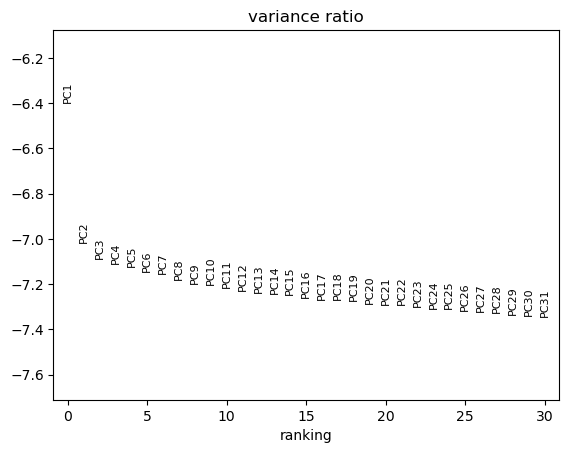

In [23]:
###########################################################################
# ANALYSIS
###########################################################################
os.system(f"mkdir -p {outdir}")

# Merge with MUON
print(f" - Merge Genomic and ADT data into Muon object")
mdata = mu.MuData({"histone": adata, "ADT": ad_adts})

mdata.var_names_make_unique()
mu.pp.intersect_obs(mdata)

###########################################################################
# PCA
print(f" - Computing PCAs")
md_histones = mdata.mod["histone"]
md_membrane = mdata.mod["ADT"]

with threadpool_limits(limits=1, user_api='blas'):  # limit to single CPU
    sc.tl.pca(md_membrane, svd_solver='arpack')
    sc.tl.pca(md_histones, svd_solver='arpack')
        
if rm_pca:
    md_histones.obsm['X_pca'] = md_histones.obsm['X_pca'][:,1:]

num_cells = len(md_histones.obs_names)
n_neighbors = int(np.sqrt(num_cells) * n_neighbors)

print(f" - Computing neighbors")
with threadpool_limits(limits=1, user_api='blas'):
    sc.pp.neighbors(md_histones, n_pcs=n_pcs, n_neighbors=n_neighbors)
    sc.pp.neighbors(md_membrane, n_pcs=n_pcs, n_neighbors=n_neighbors)

print(f" - Leiden clustering histones ({n_leiden} wanted)")
md_histones = wanted_leiden(md_histones, n_leiden)
print(f" - Leiden clustering ADTs ({n_leiden} wanted)")
md_membrane = wanted_leiden(md_membrane, n_leiden)

vms = v_measure_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])
ari = adjusted_rand_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])
f_1 = f1_score(md_histones.obs['leiden'], md_membrane.obs['leiden'], average="weighted")
print(f" - V-meassure score: {vms}")
print(f" - Adjusted Randome score: {ari}")
v_measures = {}
v_measures['leiden'] = vms

print(f" - Plotting")
with threadpool_limits(limits=1, user_api='blas'):
    sc.tl.umap(md_histones)# plot PCA

sc.pl.pca_variance_ratio(md_histones, log=True, show=False)
plt.savefig(os.path.join(outdir, "genomic_pca-weights_plot.png"))

In [24]:
###########################################################################
# compute V-measure Score
adt_names = md_membrane.var_names

out = open(os.path.join(outdir, "V-measures.tsv"), "w")
out.write(f"leiden\t{v_measures['leiden']}\n")
# We classify cells according to their abundance for each of its ADTs
for col, adt in  enumerate(adt_names):
    # cells with a total number of ADT in the top  2% will be in cluster 7
    true_cluster  = (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col],  2)).astype(int)
    # cells with a total number of ADT in the top 25% will be in cluster 6
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 25)).astype(int)
    # cells with a total number of ADT in the top 50% will be in cluster 5
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 50)).astype(int)
    # cells with a total number of ADT in the top 70% will be in cluster 4
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 70)).astype(int)
    # cells with a total number of ADT in the top 85% will be in cluster 3
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 85)).astype(int)
    # cells with a total number of ADT in the top 95% will be in cluster 2
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 95)).astype(int)
    # cells with a total number of ADT in the top 98% will be in cluster 1
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 98)).astype(int)
    # cells with a total number of ADT in the bottom 2% will be in cluster 0

    obs_cluster = md_histones.obs["leiden"]
    # This classification is compared to the leiden 
    vms = v_measure_score(true_cluster, obs_cluster)
    v_measures[adt] = vms
    out.write(f"{col}\t{vms}\n")
out.close()

In [25]:
###########################################################################
if samples["modality"] == "CITE":
    adata = mdata.mod["histone"]

    df = pd.DataFrame(adata.X, columns = ["".join(gene.split(":")[1:]) for gene in adata.var_names])

    df["leiden"] =  mdata.mod["ADT"].obs["leiden"].tolist()

    num_cells_cluster = mdata.mod["ADT"].obs["leiden"].value_counts().to_dict()

    num_cells_cluster

    bf_genes = bf.from_any(pd.read_csv(
        '/scratch2/shared/CUTAG/data/complementary_data/hg38_genes.tsv', sep='\t'))

    # add info about housekeeping genes
    fh = open('/scratch2/shared/CUTAG/data/complementary_data/Housekeeping_GenesHuman.csv')
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv('/scratch2/shared/CUTAG/data/complementary_data/Cell_marker_Human.txt', sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")

    df = df.groupby("leiden").sum()

    # iterate over rows and divide "MAFIP" by dictionary value
    for index, row in df.iterrows():
        df.loc[index] = row / num_cells_cluster[index]

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']

    ragis=dict()

    for gene in bf_genes[(bf_genes["marker Peripheral blood"] == True) | (bf_genes["housekeeping"] == True)]["name"]:
        try:
            ragis[gene] = gini(df[gene].to_numpy())
        except:
            print("")

    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')

else:
    # load GENES
    print(" - Computing RAGI")
    bf_genes = bf.from_any(pd.read_csv(
        '/scratch2/shared/CUTAG/data/complementary_data/hg38_genes.tsv', sep='\t'))

    # add info about housekeeping genes
    fh = open('/scratch2/shared/CUTAG/data/complementary_data/Housekeeping_GenesHuman.csv')
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv('/scratch2/shared/CUTAG/data/complementary_data/Cell_marker_Human.txt', sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")
    
    ###########################################################################
    # RAGI on ADTs
    fragments_path = os.path.join(genomic_sample, 'outs', 'fragments.tsv')

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']
    ragis = ragi_score(fragments_path, md_membrane, bf_genes[fun_genes], offset=10_000, clustering="leiden")
    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')

 - Computing RAGI
    => 593 marker genes in Peripheral blood, 
    => 2094 housekeeping genes in Peripheral blood, 
    - loading fragments
    - preprocessing -> gene score
    - Getting GINI of Gene scores -> RAGI


/tmp/ipykernel_841300/4130931558.py:125: RuntimeWarning: invalid value encountered in double_scalars
  return sum(abs(xi - xj) for xi, xj in permutations(tmp, 2)) / (2 * n**2 * av)


In [26]:
###########################################################################
# WNN
if wnn:
    mu.pp.neighbors(mdata, key_added='wnn', n_neighbors=n_neighbors)
    wanted_leiden(mdata, n_leiden, neighbors_key='wnn', key_added='leiden_wnn')
    mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
    mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

In [27]:
    
###########################################################################
# Summary plot
# scale ADT values for plotting
X = np.log1p(md_membrane.X)
minv = min([v for v in X.flatten() if v])
X[X==0] = minv
X -= minv
X /= max(X.flatten())

In [28]:
adts = pd.DataFrame(X, index=md_membrane.obs.index, columns=adt_names)
if samples["modality"] == "CITE":
    md_histones.obs = md_histones.obs[['n_counts', 'total_counts', 'leiden']] ###
else:
    md_histones.obs = md_histones.obs[['n_counts', 'bg_counts', 'leiden']] ###
md_histones.obs = pd.merge(md_histones.obs, adts, left_index=True, right_index=True, how="left")

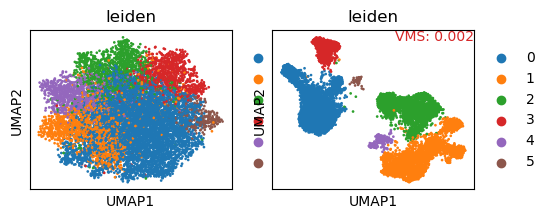

In [29]:
_ = plt.figure(figsize=(12, 12))
axe = plt.subplot(5, 4, 1)
sc.pl.umap(md_histones, size=15, ax=axe, color="leiden", show=False)
axe = plt.subplot(5, 4, 2)
if wnn:
    sc.pl.umap(mdata, size=15, ax=axe, color='leiden_wnn', show=False)
else:
    sc.tl.umap(md_membrane, random_state=10)
    sc.pl.umap(md_membrane, size=15, ax=axe, color="leiden", show=False)
x = axe.get_xlim()[1]
y = axe.get_ylim()[1]
axe.text(x, y, f"VMS: {v_measures['leiden']:.3f}", va="top", ha="right", color="tab:red")
if wnn:
    axe = plt.subplot(5, 4, 3)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color=["histone:leiden"], size=15, ax=axe, show=False)
    axe = plt.subplot(5, 4, 4)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color="ADT:leiden", size=15, ax=axe, show=False)

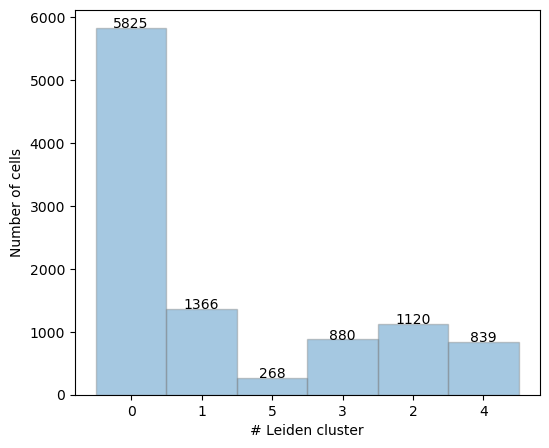

In [30]:
# for n, col in enumerate([c for c in adt_names if not c.endswith("IgD")]):
#     axe = plt.subplot(5, 4, n + 5)
#     sc.pl.umap(md_histones, size=15, ax=axe, color=col, show=False, color_map="Greys", vmin=-0.1, vmax=1.1)
#     x = axe.get_xlim()[1]
#     y = axe.get_ylim()[1]
#     axe.text(x, y, f"VMS: {v_measures[col]:.3f}", va="top", ha="right", color="tab:red")
# plt.tight_layout()
# plt.savefig(os.path.join(outdir, "UMAP_on_V-measures.png"))

# Leiden numbers
_ = plt.figure(figsize=(6, 5))
cluster_hist = plt.hist(md_histones.obs["leiden"], bins=n_leiden, 
             range=(-0.5, n_leiden - 0.5), ec="tab:grey", alpha=0.4)
for y, x in zip(cluster_hist[0], cluster_hist[1]):
    plt.text(x + 0.5, y, int(y), ha="center")
plt.ylabel("Number of cells")
plt.xlabel("# Leiden cluster")
plt.savefig(os.path.join(outdir, "Leiden_plot.png"))

In [31]:
    # save Muon object
    print(f" - Save Muon object and stats")    
    mdata.write_h5mu(os.path.join(outdir, f"{sampleID}.h5mu"))

    # compute jaccard index
    M1 = mdata['histone'].obsp['connectivities']
    M2 = mdata['ADT'].obsp['connectivities']

    stat1 = jacind(M1, M2)
    stat2 = jacind(M1, M2, binarize=True, p=1)
    
    ami = adjusted_mutual_info_score(md_histones.obs['leiden'], md_membrane.obs['leiden'])
    precision = precision_score(md_histones.obs['leiden'], md_membrane.obs['leiden'], average="weighted")
    recall = recall_score(md_histones.obs['leiden'], md_membrane.obs['leiden'], average="weighted")
    homogeneity = homogeneity_score(md_histones.obs['leiden'], md_membrane.obs['leiden'])
    completeness = completeness_score(md_histones.obs['leiden'], md_membrane.obs['leiden'])

 - Save Muon object and stats


In [32]:
    out = open(os.path.join(outdir, f"{sampleID}_stats.tsv"), "w")
    # cluster descriptive
    line = "\t".join(str(v) for v in cluster_hist[0])
    out.write(f"Number of cells per cluster\t{line}\n")
    out.write(f"Std dev. of cells per cluster\t{np.std(cluster_hist[0])}\n")
    out.write(f"Total number of cells\t{sum(cluster_hist[0])}\n")
    # correlation ADT / histone clusters
    out.write(f"VMS\t{vms}\n")
    out.write(f"ARI\t{ari}\n")
    out.write(f"F1\t{f_1}\n")
    # correlation ADT / histone graphs
    out.write(f"JAC1\t{stat1}\n")
    out.write(f"JAC2\t{stat2}\n")

    # RAGI
    ragi_marker = [v for v in bf_genes[bf_genes[f'marker {tissue}']]['ragi'] if np.isfinite(v)]
    ragi_housek = [v for v in bf_genes[bf_genes['housekeeping']]['ragi'] if np.isfinite(v)]
    r, p = mannwhitneyu(x, y)
    ragi_marker = np.median(ragi_marker)
    ragi_housek = np.median(ragi_housek)

    #XI
    xi_2 = XI(mdata.obs[["histone:leiden", "ADT:leiden"]].astype(int), 2)
    xi_3 = XI(mdata.obs[["histone:leiden", "ADT:leiden"]].astype(int), 3)
    xi_4 = XI(mdata.obs[["histone:leiden", "ADT:leiden"]].astype(int), 4)

    out.write(f"RAGI housekeeping genes\t{ragi_housek}\n")
    out.write(f"RAGI marker genes ({tissue})\t{ragi_marker}\n")
    out.write(f"RAGI ratio\t{ragi_marker / ragi_housek}\n")
    out.write(f"RAGI ratio significance\t{p}\n")
    out.write(f"RAGI ratio MannWhit. stat\t{r}\n")
    out.write(f"XI depth 2\t{xi_2}\n")
    out.write(f"XI depth 3\t{xi_3}\n")
    out.write(f"XI depth 4\t{xi_4}\n")
    out.write(f"AMI\t{ami}\n")
    out.write(f"Precision score\t{precision}\n")
    out.write(f"Recall score\t{recall}\n")
    out.write(f"Homogeneity score\t{homogeneity}\n")
    out.write(f"Completeness score\t{completeness}\n")
    out.close()
    

In [33]:
###########################################################################
# cells_clusters.csv
if wnn:
    mdata.obs[["histone:leiden","ADT:leiden","leiden_wnn"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))
else:
    mdata.obs[["histone:leiden","ADT:leiden"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))

print(f"\nDone.")


Done.


In [311]:
fragments_path

'/scratch2/shared/CUTAG/data/scCUTnTAG-PRO/GSM5849215/outs/fragments.tsv'

In [312]:
adata = md_membrane

In [313]:
bf_genes[fun_genes]

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Peripheral blood,ragi
463,567,chr13,30617920,30617920,USPL1,True,False,0.045230
467,571,chr13,30465936,30465936,HMGB1,True,False,0.111800
481,589,chr13,49792682,49792682,KPNA3,True,False,0.179905
514,630,chr13,45120510,45120510,GTF2F2,True,False,0.205251
575,718,chr20,8019761,8019761,TMX4,True,False,0.218444
...,...,...,...,...,...,...,...,...
41195,61488,chr1,167518529,167518529,CD247,False,True,0.553744
41209,61511,chr1,6785454,6785454,CAMTA1,True,False,0.167359
41317,61722,chr1,173867991,173867991,GAS5,False,True,0.176623
41327,61735,chr1,11262528,11262528,MTOR,True,False,0.055343


In [314]:
uwu = bf_genes[fun_genes].sort_values(by=['ragi'], ascending=False)

In [315]:
uwu.tail(50)

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Peripheral blood,ragi
21324,32961,chr2,176269395,176269395,MTX2,True,False,0.032005
32794,49299,chr10,87863438,87863438,PTEN,True,False,0.027779
9993,15857,chr18,3262417,3262417,MYL12B,True,False,0.023771
880,1195,chr20,37749851,37749851,CTNNBL1,True,False,NaN
2099,3070,chr21,44119159,44119159,PWP2,True,False,NaN
2573,3846,chr21,43107524,43107524,U2AF1,True,False,NaN
2854,4294,chr22,40966201,40966201,RBX1,True,False,NaN
4364,6793,chr9,96483025,96483025,HABP4,True,False,NaN
4687,7319,chr19,3314403,3314403,NFIC,True,False,NaN
5667,8826,chr4,24539150,24539150,DHX15,True,False,NaN


In [316]:
gene1="CD22"
gene2="ACTR3"

In [317]:
uwu_filtered = uwu[uwu['name'].isin([gene1, gene2])]

In [318]:
uwu_filtered

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Peripheral blood,ragi
15199,23878,chr19,35329187,35329187,CD22,False,True,0.786715
12464,19703,chr2,113890089,113890089,ACTR3,True,False,0.050294


In [319]:
genes = uwu_filtered

In [320]:
offset=10_000

In [321]:
clustering="leiden"

In [322]:
fragments_path

'/scratch2/shared/CUTAG/data/scCUTnTAG-PRO/GSM5849215/outs/fragments.tsv'

In [323]:
max_len=1000

In [324]:
    print("    - loading fragments")
    fragments = _read_fragments_with_offset(fragments_path, adata, 
                                            offset=offset, max_len=max_len)
    
    print("    - preprocessing -> gene score")
    # compute overlap with genes TSS
    frag_dist = bf.overlap(fragments, df2=genes, how='inner')
    # compute distance between fragment center and TSS
    frag_dist['distance'] = (frag_dist['center'] - frag_dist['start_']).abs()
    
    # cleanup
    frag_dist = frag_dist[['chrom', 'start', 'end', 'tag', 'center', 'name_', 'distance']]
    frag_dist = frag_dist.rename(columns={'name_': 'gene'})
    
    # concatenate to closest fragments by genes
    gene_scores = frag_dist[['tag', 'gene', 'distance']].groupby(
        ['tag', 'gene'])['distance'].apply(list).reset_index()
    
    # Convert distances to score
    gene_scores['scores'] = gene_scores['distance'].apply(
        lambda x: [math.exp( -e / 5000) for e in x])

    - loading fragments
    - preprocessing -> gene score


In [325]:
gene_scores

,tag,gene,distance,scores
0,AAACGAACATTCACCC-1,CD22,[2081],[0.6595483476230181]
1,AAACGAATCAGTCACA-1,CD22,"[95, 229]","[0.981179362242806, 0.9552329896852655]"
2,AAACGAATCGCAACTA-1,ACTR3,[1],[0.9998000199986667]
3,AAACTCGCATTAGCAC-1,ACTR3,[740],[0.8624311149420455]
4,AAACTCGGTTGAATAG-1,ACTR3,"[487, 275]","[0.9071930563256202, 0.9464851479534838]"
...,...,...,...,...
522,TTTGCGCTCTATACCT-1,ACTR3,[710],[0.867621256485914]
523,TTTGCGCTCTCTTAAC-1,ACTR3,[909],[0.8337680773569568]
524,TTTGGCCTCAAAGTAG-1,ACTR3,[3598],[0.48694699580772866]
525,TTTGGCCTCGGGATCC-1,ACTR3,[3299],[0.5169547150963134]


In [326]:
    # merge with Leiden clusters
    gene_scores = gene_scores.merge(adata.obs[clustering], left_on='tag', right_index=True, 
                                    how='inner')
    gene_scores = gene_scores.rename(columns={clustering: 'cluster'})
    
    # sumup distance scores -> 1 gene per cell per cluster has 1 score
    gene_scores['sum_score'] = gene_scores['scores'].apply(lambda x: sum(x))

In [327]:
gene_scores_gene1 = gene_scores[gene_scores["gene"]==gene1]
gene_scores_gene2 = gene_scores[gene_scores["gene"]==gene2]

In [329]:
gene1_dict = dict(zip(gene_scores_gene1['tag'], gene_scores_gene1['sum_score']))

In [331]:
gene2_dict = dict(zip(gene_scores_gene2['tag'], gene_scores_gene2['sum_score']))

In [339]:
gene1 = gene1.lower()

In [340]:
md_membrane.obs[gene1] = md_membrane.obs.index.map(gene1_dict).fillna(0).astype(float)

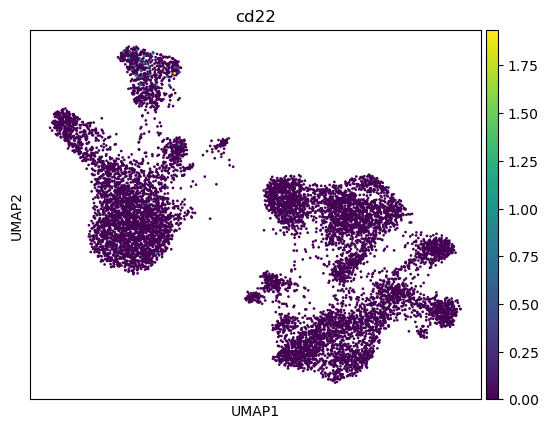

In [341]:
sc.pl.umap(md_membrane, size=15, color=gene1)

In [342]:
md_membrane.obs[gene2] = md_membrane.obs.index.map(gene2_dict).fillna(0).astype(float)

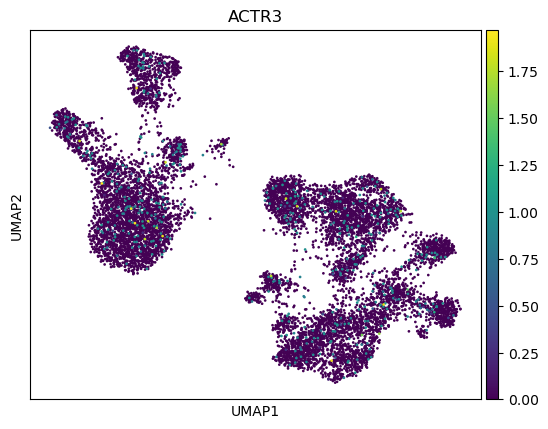

In [343]:
sc.pl.umap(md_membrane, size=15, color=gene2)

In [344]:
def plot_smoothed(adata, gene, k=10):
    "It requires the gene scores column to be in adata.obs"
    # extract the connectivities matrix from adata.obsp
    connectivities_matrix = adata.obsp['connectivities']

    # convert connectivities matrix to pandas dataframe
    connectivities_df = pd.DataFrame.sparse.from_spmatrix(connectivities_matrix,
                                                          index=adata.obs.index,
                                                          columns=adata.obs.index)

    result_dict = {}
    for col in connectivities_df.columns:

        top_values = connectivities_df[col].loc[connectivities_df[col] != 0]
        if len(top_values) >= k:
            top_values = top_values.sort_values(ascending=False)[0:k]
            result_dict[col] = top_values.index.tolist()        
        else:
            top_values = top_values.sort_values(ascending=False)
            result_dict[col] = top_values.index.tolist()

    # create a dictionary with the mean values of the cd22 column for each key in result_dict
    gene_dict = {}
    for key, value_list in result_dict.items():
        gene_mean = adata.obs.loc[value_list, gene].mean()
        gene_dict[key] = gene_mean

    # create a new column called cd22_smoothed and set the values using the cd22_dict
    adata.obs[gene+'_smoothed'] = adata.obs.index.map(lambda x: gene_dict.get(x, 0))
    
    sc.pl.umap(adata, color = gene+"_smoothed")
    
    del adata.obs[gene+'_smoothed']

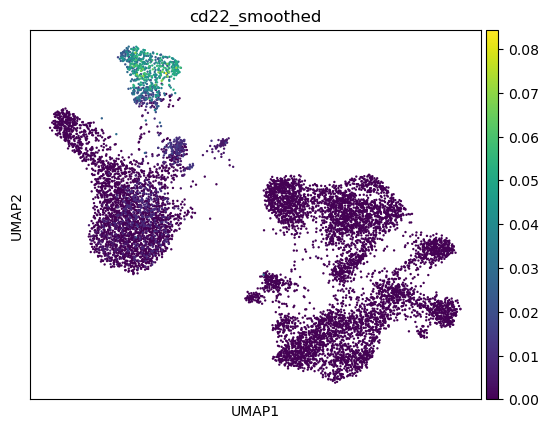

In [345]:
plot_smoothed(md_membrane, gene1, k=100)

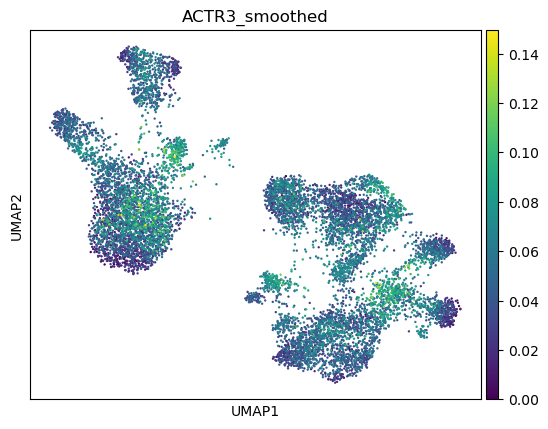

In [346]:
plot_smoothed(md_membrane, gene2, k=100)

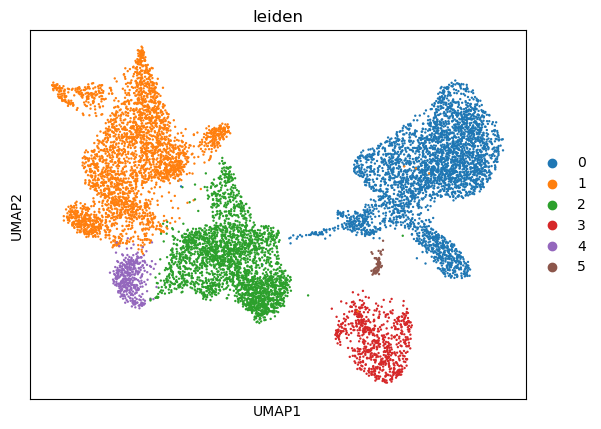

In [383]:
sc.pl.umap(md_membrane, color="leiden")

In [ ]:
#bg 

/tmp/ipykernel_803216/4074083126.py:12: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df = (df > 0).astype(int)


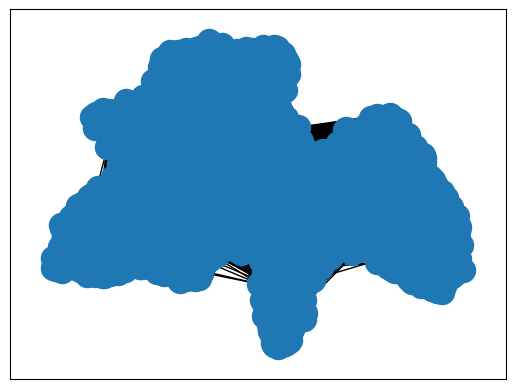

In [421]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# extract the connectivities matrix from adata.obsp
connectivities_matrix = md_membrane.obsp['connectivities']

# convert connectivities matrix to pandas dataframe
df = pd.DataFrame.sparse.from_spmatrix(connectivities_matrix,
                                                      index=md_membrane.obs.index,
                                                      columns=md_membrane.obs.index)
df = (df > 0).astype(int)

# create a NetworkX graph object from the pandas dataframe
G = nx.from_pandas_adjacency(df)

# draw the graph using the spring layout algorithm
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False)

# show the plot
plt.show()


/tmp/ipykernel_803216/878454077.py:12: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df = (df > 0).astype(int)


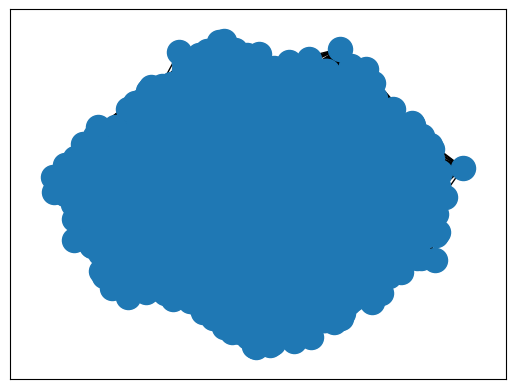

In [422]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# extract the connectivities matrix from adata.obsp
connectivities_matrix = md_histones.obsp['connectivities']

# convert connectivities matrix to pandas dataframe
df = pd.DataFrame.sparse.from_spmatrix(connectivities_matrix,
                                                      index=md_histones.obs.index,
                                                      columns=md_histones.obs.index)
df = (df > 0).astype(int)

# create a NetworkX graph object from the pandas dataframe
G = nx.from_pandas_adjacency(df)

# draw the graph using the spring layout algorithm
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False)

# show the plot
plt.show()


In [ ]:
#no

/tmp/ipykernel_803216/4074083126.py:12: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df = (df > 0).astype(int)


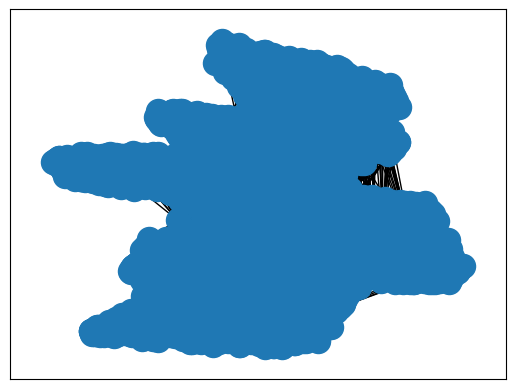

In [391]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# extract the connectivities matrix from adata.obsp
connectivities_matrix = md_membrane.obsp['connectivities']

# convert connectivities matrix to pandas dataframe
df = pd.DataFrame.sparse.from_spmatrix(connectivities_matrix,
                                                      index=md_membrane.obs.index,
                                                      columns=md_membrane.obs.index)
df = (df > 0).astype(int)

# create a NetworkX graph object from the pandas dataframe
G = nx.from_pandas_adjacency(df)

# draw the graph using the spring layout algorithm
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False)

# show the plot
plt.show()


/tmp/ipykernel_803216/878454077.py:12: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df = (df > 0).astype(int)


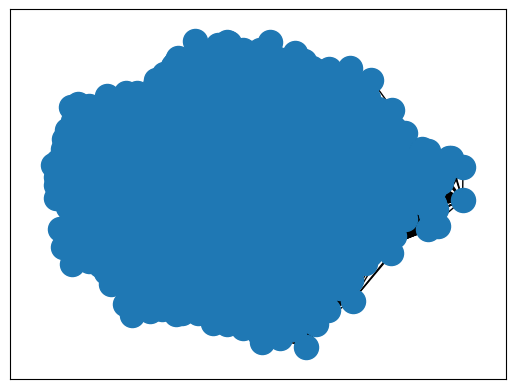

In [392]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# extract the connectivities matrix from adata.obsp
connectivities_matrix = md_histones.obsp['connectivities']

# convert connectivities matrix to pandas dataframe
df = pd.DataFrame.sparse.from_spmatrix(connectivities_matrix,
                                                      index=md_histones.obs.index,
                                                      columns=md_histones.obs.index)
df = (df > 0).astype(int)

# create a NetworkX graph object from the pandas dataframe
G = nx.from_pandas_adjacency(df)

# draw the graph using the spring layout algorithm
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False)

# show the plot
plt.show()


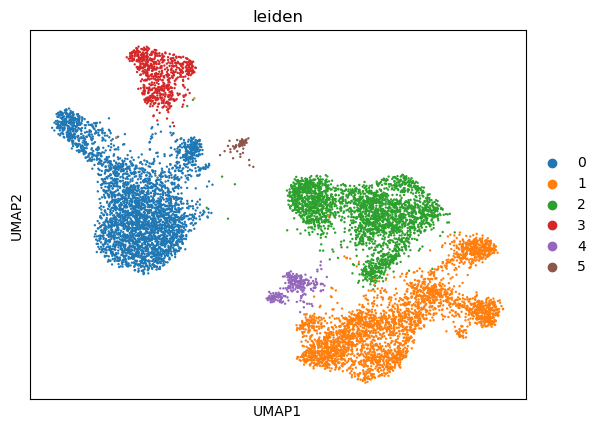

In [347]:
sc.pl.umap(md_membrane, color="leiden")

In [348]:
uwu_filtered

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Peripheral blood,ragi
15199,23878,chr19,35329187,35329187,CD22,False,True,0.786715
12464,19703,chr2,113890089,113890089,ACTR3,True,False,0.050294
